## Project: Image classification for color images

### Import dependencies

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers, optimizers

import numpy as np
import matplotlib.pyplot as plt

### Preprocessing

In [3]:
# Load the preshuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# Split the dataset for training and validation
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Normalize the data
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# One-hot encode the labels
num_classes = 10
y_train = utils.to_categorical(y_train,num_classes)
y_valid = utils.to_categorical(y_valid,num_classes)
y_test = utils.to_categorical(y_test,num_classes)

### Data augmentation

In [4]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

### Build the model architecture

In [5]:
base_hidden_units = 32
weight_decay = 1e-4
model = Sequential()
 
# CONV1
model.add(Conv2D(base_hidden_units, kernel_size= 3, padding='same',
         kernel_regularizer=regularizers.l2(weight_decay),
input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV2
model.add(Conv2D(base_hidden_units, kernel_size= 3, padding='same', 
         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
# CONV3
model.add(Conv2D(base_hidden_units * 2, kernel_size= 3, padding='same',
         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV4
model.add(Conv2D(base_hidden_units * 2, kernel_size= 3, padding='same', 
         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
# CONV5
model.add(Conv2D(base_hidden_units * 4, kernel_size= 3, padding='same', 
         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# CONV6
model.add(Conv2D(base_hidden_units * 4, kernel_size= 3, padding='same',
         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
 
# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

### Train the model

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
batch_size = 128
epochs = 150
 
checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, 
                               save_best_only=True )
optimizer = Adam(lr=0.0001,decay=1e-6)
 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
 
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer], steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=2, validation_data=(x_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
351/351 - 31s - loss: 2.8442 - accuracy: 0.2745 - val_loss: 2.1222 - val_accuracy: 0.2846

Epoch 00001: val_loss improved from inf to 2.12223, saving model to model.100epochs.hdf5
Epoch 2/150
351/351 - 29s - loss: 2.1782 - accuracy: 0.3539 - val_loss: 1.5024 - val_accuracy: 0.4766

Epoch 00002: val_loss improved from 2.12223 to 1.50244, saving model to model.100epochs.hdf5
Epoch 3/150
351/351 - 29s - loss: 1.9262 - accuracy: 0.3921 - val_loss: 1.4771 - val_accuracy: 0.4876

Epoch 00003: val_loss improved from 1.50244 to 1.47709, saving model to model.100epochs.hdf5
Epoch 4/150
351/351 - 29s - loss: 1.7608 - accuracy: 0.4275 - val_loss: 1.4066 - val_accuracy: 0.5108

Epoch 00004: val_loss improved from 1.47709 to 1.40663, saving model to model.100epochs.hdf5
Epoch 5/150
351/351 - 29s - loss: 1.6462 - accuracy: 0.4557 - val_loss: 1.3992 - val_accuracy: 0.5088

Epoch 00005: val_loss improved from 1.40663 to 1.39924, saving model to model.100epochs.hdf5
Epoch 6/150
351/351 - 28

### Evaluate the model

79/79 [==============================] - 1s 12ms/step - loss: 0.5268 - accuracy: 0.8443

Test result: 84.430 loss: 0.527


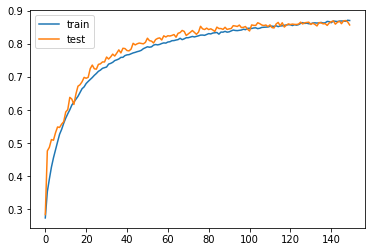

In [15]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()